In [1]:
import scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import socket

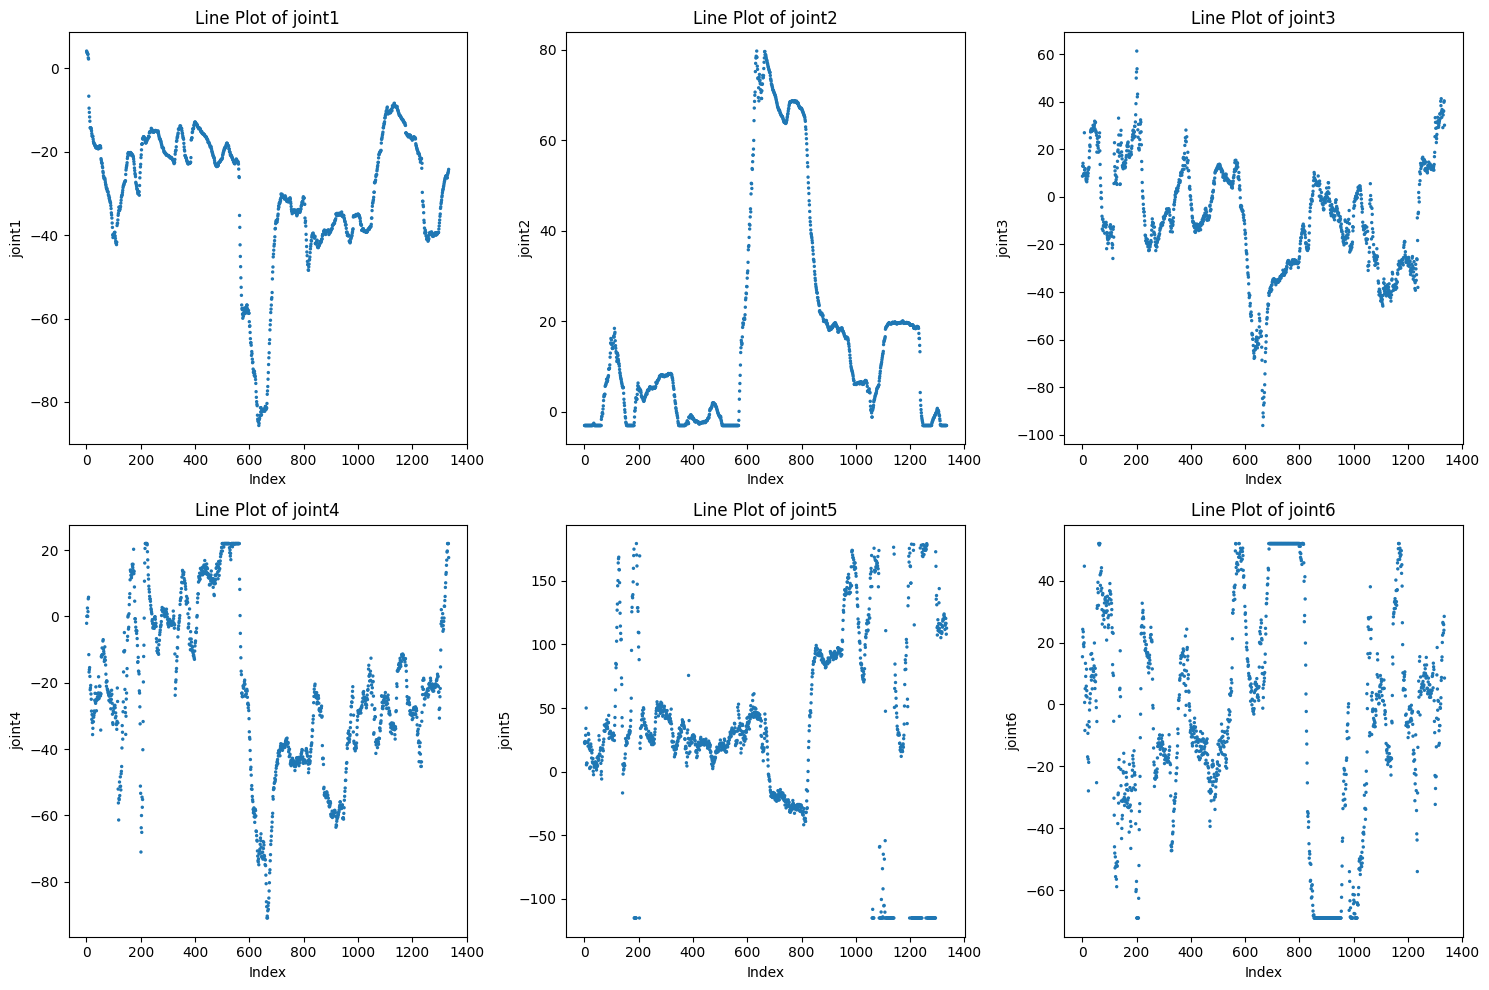

In [2]:
# Define the name of the CSV file
csv_filename = '/home/giakhang/tomo2_imaging/src/tomo_operator_control/tomo_operator_control/joint_angles_6_dof_2.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(csv_filename)

# Check if the DataFrame has 6 columns
if df.shape[1] != 6:
    raise ValueError("The CSV file does not have 6 columns.")

# Create a figure and a set of subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Flatten the array of axes for easy iteration
axs = axs.flatten()

# Iterate over each column and create a scatter plot
for i, column in enumerate(df.columns):
    column_data = df[column].to_list()
    #axs[i].plot(list(range(1, len(column_data) + 1)), column_data, marker='o', markersize=1)  # Plot with markers
    axs[i].scatter(list(range(1, len(column_data) + 1)), 
        column_data, 
        sizes=[2] * len(column_data))
    axs[i].set_title(f'Line Plot of {column}')
    axs[i].set_xlabel('Index')
    axs[i].set_ylabel(column)

# Adjust layout to make room for the titles
plt.tight_layout()

# Save the figure to a file or show it
plt.show()  # Or display in a window

In [11]:
# Ma trận chuyển đổi trạng thái
A = np.array([[1]])
# Ma trận hiệp phương sai nhiễu hệ thống
Q = np.array([[1e-8]])
# Ma trận mô hình quan sát
G = np.array([[1]])
# Ma trận hiệp phương sai nhiễu quan sát
#_noise_degree_per_second = 10
#system_noise_degree_per_frame_ms = (1000 / FPS) * system_noise_degree_per_second / 1000
R = np.array([[0.01]])

def kalman_filter(angles_of_joint):
    #R = np.array([[angles_of_joint.std()]])
    optimal_estimate_angles = []
    x_init = np.array([[0]])
    sigma_init = np.array([[1]])

    x_hat, sigma = x_init, sigma_init
    for i in range(len(angles_of_joint)):
        # Prediction
        x_hat = A @ x_hat
        sigma = A @ sigma @ A.T + Q

        # Measurement
        y = angles_of_joint[i]
        kalman_gain = sigma @ G.T @ np.linalg.inv(G @ sigma @ G.T + R)
        x_hat = x_hat + kalman_gain @ (y - G @ x_hat)
        sigma = (np.eye(len(sigma)) - kalman_gain @ G) @ sigma
        optimal_estimate_angles.append(x_hat.squeeze())

    return optimal_estimate_angles

In [12]:
sending_data = []

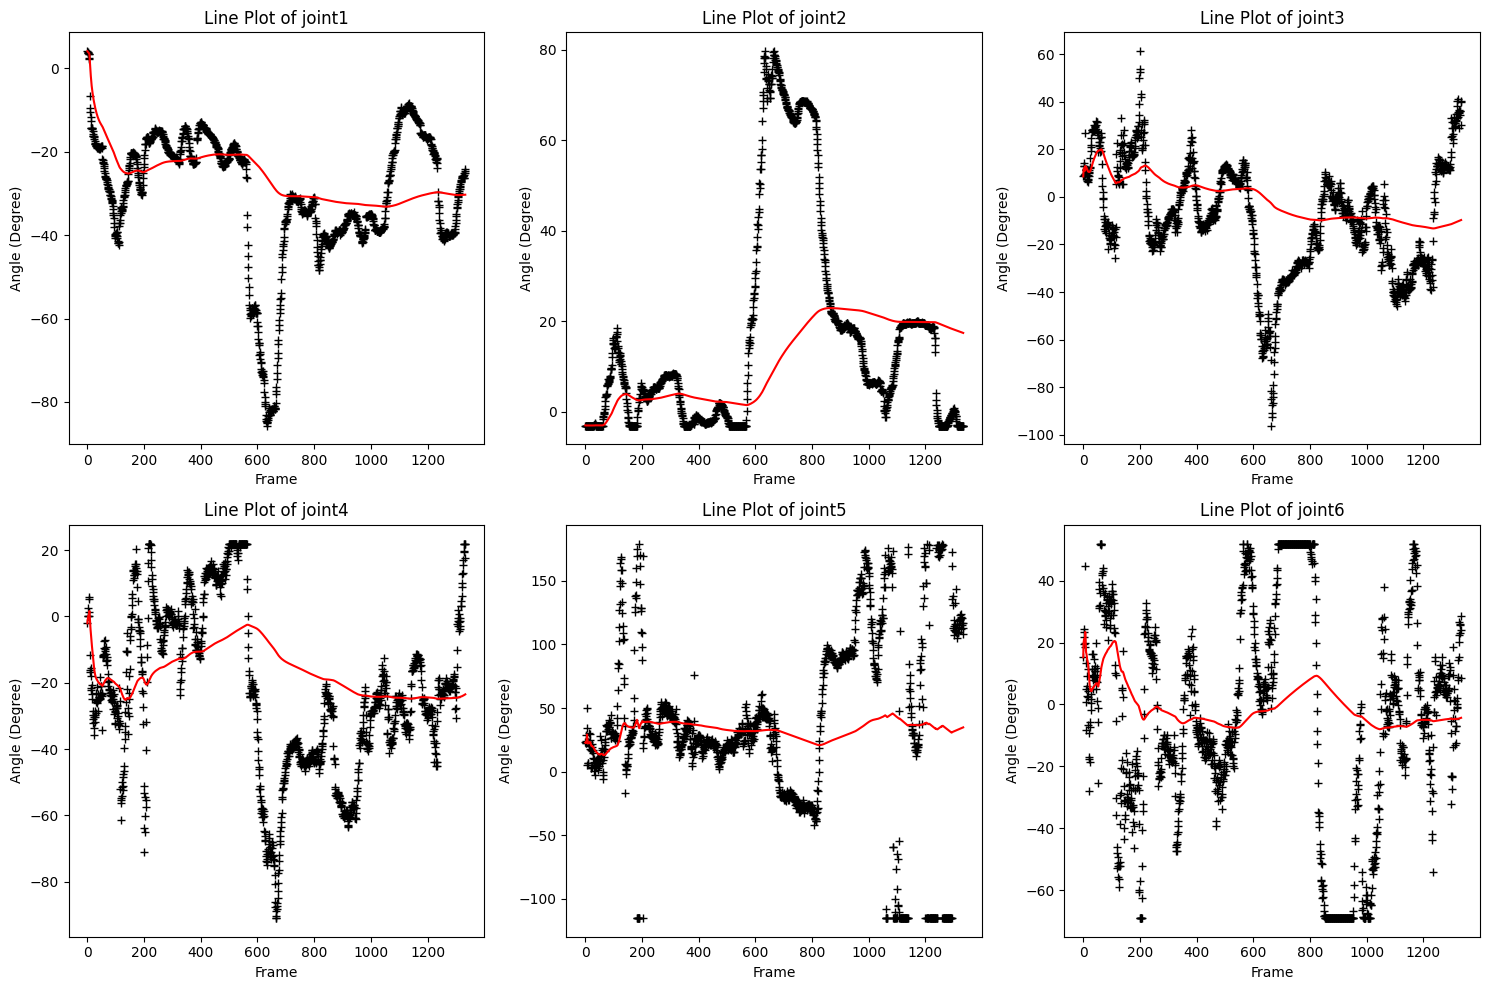

In [13]:
# Create a figure and a set of subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Flatten the array of axes for easy iteration
axs = axs.flatten()

# Iterate over each column and create a scatter plot
for i, column in enumerate(df.columns):
    column_data = df[column].to_numpy()
    optimal_estimate_angles = kalman_filter(column_data)
    sending_data.append(optimal_estimate_angles)
    
    axs[i].plot(column_data, "k+", label="Measurement")  # Plot with markers
    axs[i].plot(optimal_estimate_angles,'r-',label='Estimate Angle')
    axs[i].set_title(f'Line Plot of {column}')
    axs[i].set_xlabel('Frame')
    axs[i].set_ylabel("Angle (Degree)")

# Adjust layout to make room for the titles
plt.tight_layout()

# Save the figure to a file or show it
plt.show()  # Or display in a window

In [10]:
sending_data = np.array(sending_data)
sending_data = sending_data.T
sending_data.shape

(1334, 6)

In [8]:
sending_data = sending_data * math.pi / 180
client_socket = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
server_ip = "192.168.0.170"
server_port = 12000

In [9]:
fps = 25
start_time = time.time()
for i in range(sending_data.shape[0]):
    angles = sending_data[i, :]
    angles = angles.tolist()
    end_time = time.time()
    elapsed_time = end_time - start_time
    start_time = end_time
    angles.append(elapsed_time)
    message = str(angles)
    print(message)
    client_socket.sendto(message.encode(), (server_ip, server_port))
    time.sleep(1 / fps)    

[0.0716411163991468, -0.05184151425362425, 0.15022481769970725, -0.03567605484259812, 0.39900965805593647, 0.2666571555660879, 5.888938903808594e-05]
[0.06952566685245588, -0.052100708863878985, 0.18831094022918496, -0.01771636615433656, 0.3932564090965077, 0.3451673282148704, 0.040445804595947266]
[0.06805759559694412, -0.052188245503016144, 0.20794708289719432, -0.010978059206073431, 0.40045503702224594, 0.35691754791708047, 0.04022049903869629]
[0.06682054377427077, -0.05223253133715945, 0.21193553648427224, 0.0032714924942264913, 0.3994800195414869, 0.3706655859906492, 0.04024815559387207]
[0.06539544603911343, -0.05225944898303943, 0.20073083474572265, 0.002680929022928869, 0.42073418859482725, 0.36391091396433956, 0.04018354415893555]
[0.06408698451852907, -0.052277651641212584, 0.1952729290186522, 0.006774105199488546, 0.45208096381257296, 0.3570867687031533, 0.04019045829772949]
[0.060882200250205167, -0.05229085264205019, 0.1903185485219417, 0.020576097330643774, 0.51976061221

In [ ]:
R = np.array([[angles_of_joint.std()]])
optimal_estimate_angles = []
x_init = np.array([[0]])
sigma_init = np.array([[2]])

x_hat, sigma = x_init, sigma_init
for i in range(len(angles_of_joint)):
    # Prediction
    x_hat = A @ x_hat
    sigma = A @ sigma @ A.T + Q

    # Measurement
    y = angles_of_joint[i]
    kalman_gain = sigma @ G.T @ np.linalg.inv(G @ sigma @ G.T + R)
    x_hat = x_hat + kalman_gain @ (y - G @ x_hat)
    sigma = (np.eye(len(sigma)) - kalman_gain @ G) @ sigma
    optimal_estimate_angles.append(x_hat.squeeze())

return optimal_estimate_angles

In [ ]:
G = np.array([[1]])

A = np.array([[1]])
#Q = R / 100
Q = np.array([[1e-3]])

x_hat = np.array([[0]])
sigma = np.array([[2]])


optimal_estimate_x = []

In [3]:
angles_measurements = np.array([
    df["joint1"].to_numpy(),
    df["joint2"].to_numpy(),
    df["joint3"].to_numpy(),
    df["joint4"].to_numpy(),
    df["joint5"].to_numpy(),
    df["joint6"].to_numpy()]).T

In [4]:
angles_measurements.shape

(1334, 6)

In [5]:
fps = 30
max_angles_of_each_second_rad = np.array([1.5184, 1.5184, 2.1074, 2.1074, 3.3719, 3.3719])
max_angles_of_each_second_deg = max_angles_of_each_second_rad * 180 / math.pi
max_angles_of_each_ms_deg = (max_angles_of_each_second_deg * (1000 / fps)) / 1000 
#sigma = max_angles_of_each_ms_deg

In [6]:
max_angles_of_each_ms_deg

array([2.89993039, 2.89993039, 4.02483752, 4.02483752, 6.43985463,
       6.43985463])

In [7]:
A = np.eye(angles_measurements.shape[1])
Q = np.eye(angles_measurements.shape[1]) * 1
G = np.eye(angles_measurements.shape[1])
R = np.cov(angles_measurements, rowvar=False)

x_hat = np.array([[0, 0, 0, 0, 0, 0]]).T
sigma = np.eye(angles_measurements.shape[1]) * max_angles_of_each_ms_deg

optimal_estimated_angles = []

for i in range(angles_measurements.shape[0]):
    # Prediction
    x_hat = A @ x_hat
    sigma = A @ sigma @ A.T + Q

    # Measurement
    y = angles_measurements[i, :][:, None]
    kalman_gain = sigma @ G.T @ np.linalg.inv(G @ sigma @ G.T + R)
    x_hat = x_hat + kalman_gain @ (y - G @ x_hat)
    sigma = (np.eye(len(sigma)) - kalman_gain @ G) @ sigma
    optimal_estimated_angles.append(x_hat.squeeze())

In [8]:
optimal_estimated_angles = np.array(optimal_estimated_angles)

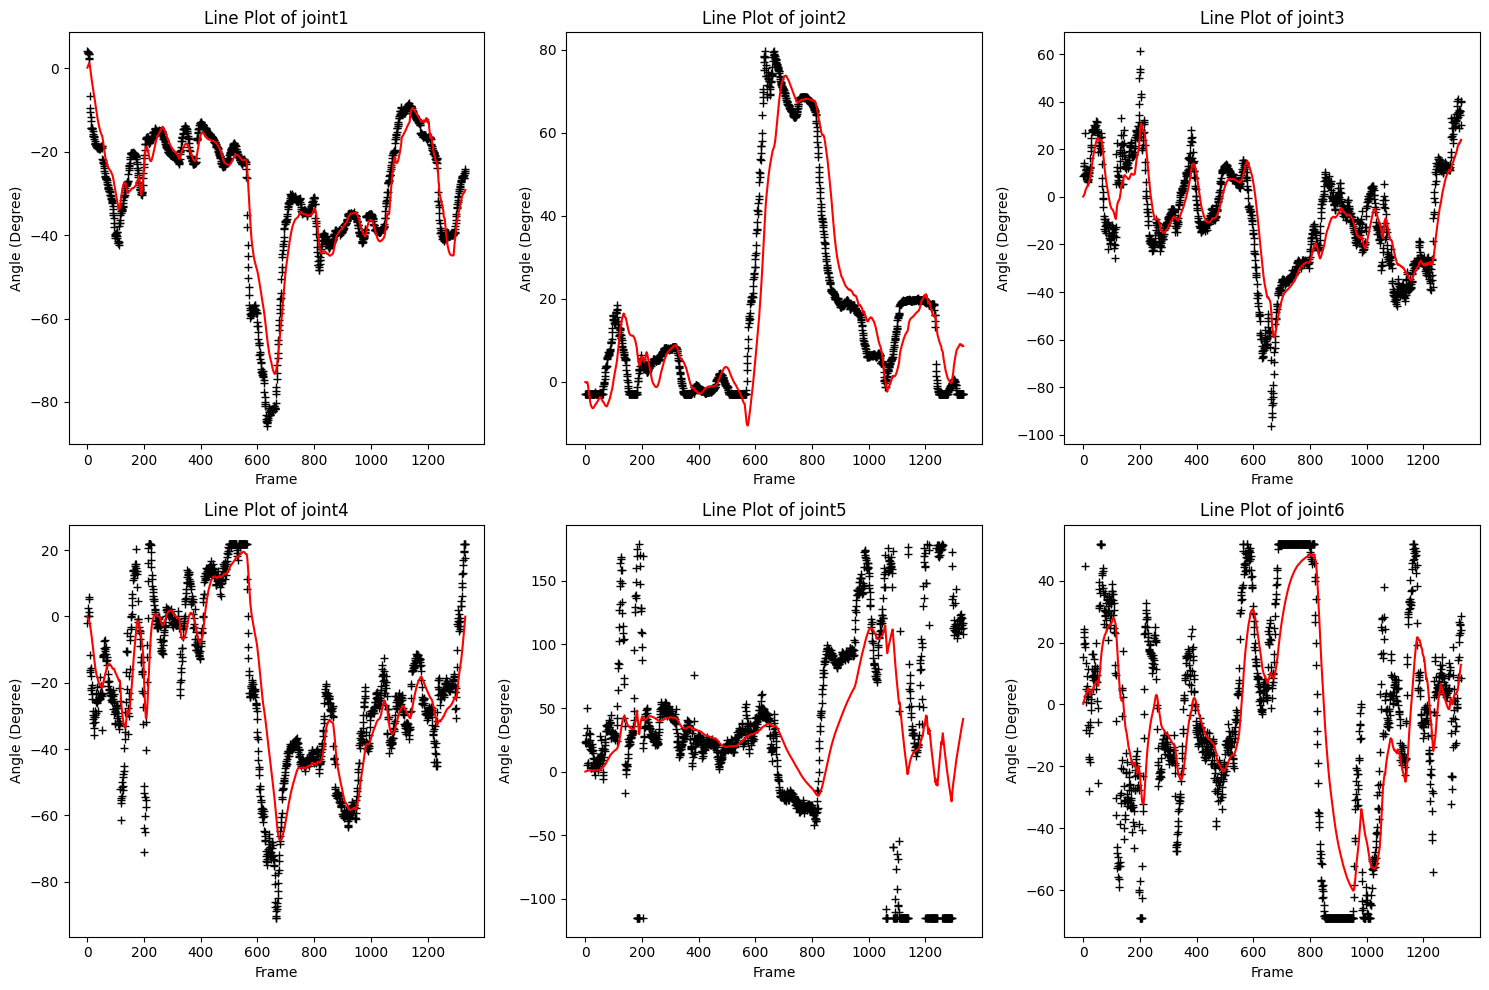

In [9]:
# Create a figure and a set of subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Flatten the array of axes for easy iteration
axs = axs.flatten()

# Iterate over each column and create a scatter plot
for i, column in enumerate(df.columns):
    column_data = df[column].to_numpy()
    optimal_estimated_angles_of_joint_i = optimal_estimated_angles[:, i]
    
    axs[i].plot(column_data, "k+", label="Measurement")  # Plot with markers
    axs[i].plot(optimal_estimated_angles_of_joint_i,'r-',label='Estimate Angle')
    axs[i].set_title(f'Line Plot of {column}')
    axs[i].set_xlabel('Frame')
    axs[i].set_ylabel("Angle (Degree)")

# Adjust layout to make room for the titles
plt.tight_layout()

# Save the figure to a file or show it
plt.show()  # Or display in a window

In [10]:
optimal_estimated_angles.shape

(1334, 6)

In [11]:
optimal_estimated_angles_rad = optimal_estimated_angles * math.pi / 180
client_socket = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
server_ip = "192.168.0.170"
server_port = 12000

In [12]:
start_time = time.time()
for i in range(optimal_estimated_angles_rad.shape[0]):
    angles = optimal_estimated_angles_rad[i, :]
    angles = angles.tolist()
    end_time = time.time()
    elapsed_time = end_time - start_time
    start_time = end_time
    angles.append(elapsed_time)
    message = str(angles)
    print(message)
    client_socket.sendto(message.encode(), (server_ip, server_port))
    time.sleep(1 / fps)    

[0.003028377273666825, -0.000772183816203193, 0.0025300356286727657, -0.003896971951260058, 0.0011356954618000719, 0.003910873303493183, 0.00012230873107910156]
[0.006348449624144454, -0.0013053436625560723, 0.007045345728766542, -0.008314658197912623, 0.0025031227743640794, 0.009526829019704664, 0.034131765365600586]
[0.009953592727026042, -0.00133469259893039, 0.01250465078735028, -0.012734279829597196, 0.003974564540312512, 0.015108948913978876, 0.03352522850036621]
[0.01305692564928293, -0.0013306477128797655, 0.01760347418558701, -0.016074476445267948, 0.005581303583902646, 0.021011216916656358, 0.03354835510253906]
[0.016533789568197812, -0.002539019958729465, 0.021047935417418943, -0.02009827858483208, 0.007520777067502645, 0.0268078370652214, 0.03355264663696289]
[0.01985774307356417, -0.0029447690670417613, 0.024821173010409873, -0.023071055152364576, 0.009835230503801884, 0.032622595141476994, 0.033640384674072266]
[0.022116647127734243, -0.0022787360354724795, 0.027836309590

In [85]:
FPS = 20
delta_t = 0.5
A = np.array([[1, delta_t_ms], [0, 1]])
Q = np.array([[0.1, 0], [0, 0.1]])
G = np.array([[1, 0]])
R = np.array([[0.05]])

x_hat = np.array([0, 5])
sigma = np.array([[0.01, 0], [0, 1]])

In [ ]:
def kalman_filter(angles_of_joint):
    R = np.array([[angles_of_joint.std()]])
    optimal_estimate_angles = []
    x_init = np.array([[0]])
    sigma_init = np.array([[2]])

    x_hat, sigma = x_init, sigma_init
    for i in range(len(angles_of_joint)):
        # Prediction
        x_hat = A @ x_hat
        sigma = A @ sigma @ A.T + Q

        # Measurement
        y = angles_of_joint[i]
        kalman_gain = sigma @ G.T @ np.linalg.inv(G @ sigma @ G.T + R)
        x_hat = x_hat + kalman_gain @ (y - G @ x_hat)
        sigma = (np.eye(len(sigma)) - kalman_gain @ G) @ sigma
        optimal_estimate_angles.append(x_hat.squeeze())

    return optimal_estimate_angles

In [42]:
x_hat = A @ x_hat 

In [44]:
sigma = A @ sigma @ A.T + Q

In [46]:
kalman_gain = sigma @ G.T @ np.linalg.inv(G @ sigma @ G.T + R)

In [47]:
x_hat = x_hat + kalman_gain @ (2.2 - G @ x_hat)

In [49]:
sigma = (np.eye(len(sigma)) - kalman_gain @ G) @ sigma

In [86]:
FPS = 20
delta_t_ms = 1000 / 20
system_noise_degree_per_second = 1
system_noise_degree_per_frame_ms = (1000 / FPS) * system_noise_degree_per_second / 1000

A = np.array([[1, delta_t_ms], [0, 1]])
Q = np.array([[system_noise_degree_per_frame_ms, 0], [0, system_noise_degree_per_frame_ms]])
G = np.array([[1, 0]])
R = np.array([[system_noise_degree_per_frame_ms / 2]])

joint_1_max_degree_velocity_per_second = 86.998
joint_1_max_degree_velocity_per_frame_ms = joint_1_max_degree_velocity_per_second * (1000 / FPS) / 1000
x_init = np.array([0, joint_1_max_degree_velocity_per_frame_ms])
sigma_init = np.array([[0.01, 0], [0, 1]])

def kalman_filter(angles_measurements, x_init, sigma_init):
    optimal_estimate_angles = []

    x_hat, sigma = x_init, sigma_init
    for i in range(len(angles_measurements)):
        # Prediction
        x_hat = A @ x_hat
        sigma = A @ sigma @ A.T + Q

        # Measurement
        y = angles_measurements[i]
        kalman_gain = sigma @ G.T @ np.linalg.inv(G @ sigma @ G.T + R)
        x_hat = x_hat + kalman_gain @ (y - G @ x_hat)
        sigma = (np.eye(len(sigma)) - kalman_gain @ G) @ sigma
        
        optimal_estimate_angles.append(x_hat[0])

    return optimal_estimate_angles

In [87]:
df["joint1"].to_numpy()

array([  4.14577684,   3.86233307,   3.7344911 , ..., -24.98473835,
       -24.64014734, -24.22410966])

In [88]:
rs = kalman_filter(df["joint1"].to_numpy(), x_init, sigma_init)

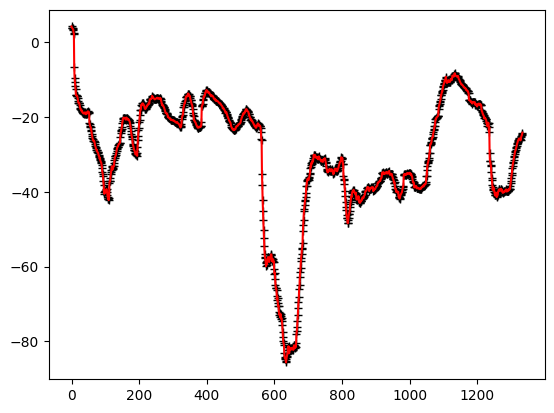

In [89]:
plt.plot(df["joint1"].to_numpy(), "k+", label="Measurement")  # Plot with markers
plt.plot(rs,'r-',label='Estimate Angle')

In [ ]:
# Create a figure and a set of subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Flatten the array of axes for easy iteration
axs = axs.flatten()

# Iterate over each column and create a scatter plot
for i, column in enumerate(df.columns):
    column_data = df[column].to_numpy()
    optimal_estimate_angles = kalman_filter(column_data)
    
    axs[i].plot(column_data, "k+", label="Measurement")  # Plot with markers
    axs[i].plot(optimal_estimate_angles,'r-',label='Estimate Angle')
    axs[i].set_title(f'Line Plot of {column}')
    axs[i].set_xlabel('Frame')
    axs[i].set_ylabel("Angle (Degree)")

# Adjust layout to make room for the titles
plt.tight_layout()

# Save the figure to a file or show it
plt.show()  # Or display in a window